In [ ]:
! pip install pycaret[full]
! pip install markupsafe==2.0.1

# 1. 옛날 버전


In [ ]:
! pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

In [ ]:
# 훈련, 검증, 테스트셋 분류
#final = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/final.csv', encoding='cp949').drop('yyyymmdd', axis=1)
final = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/final_ver2.csv', encoding='cp949')#.drop('yyyymmdd', axis=1)
df = final[final['year'] != 2016]
train = df[df['year'] != 2015]
val = df[df['year'] == 2015]
test = final[final['year'] == 2016].drop('frequency', axis=1)

X_train = train.drop('frequency', axis=1)
y_train = train['frequency']
X_val = val.drop('frequency', axis=1)
y_val = val['frequency']

# 최종 증감분 계산 
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

# K-Fold 
def kfold(model, tr):
    cv_accuracy = []
    cv = KFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(tr, tr['frequency']):
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y)
        score = RMSE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_

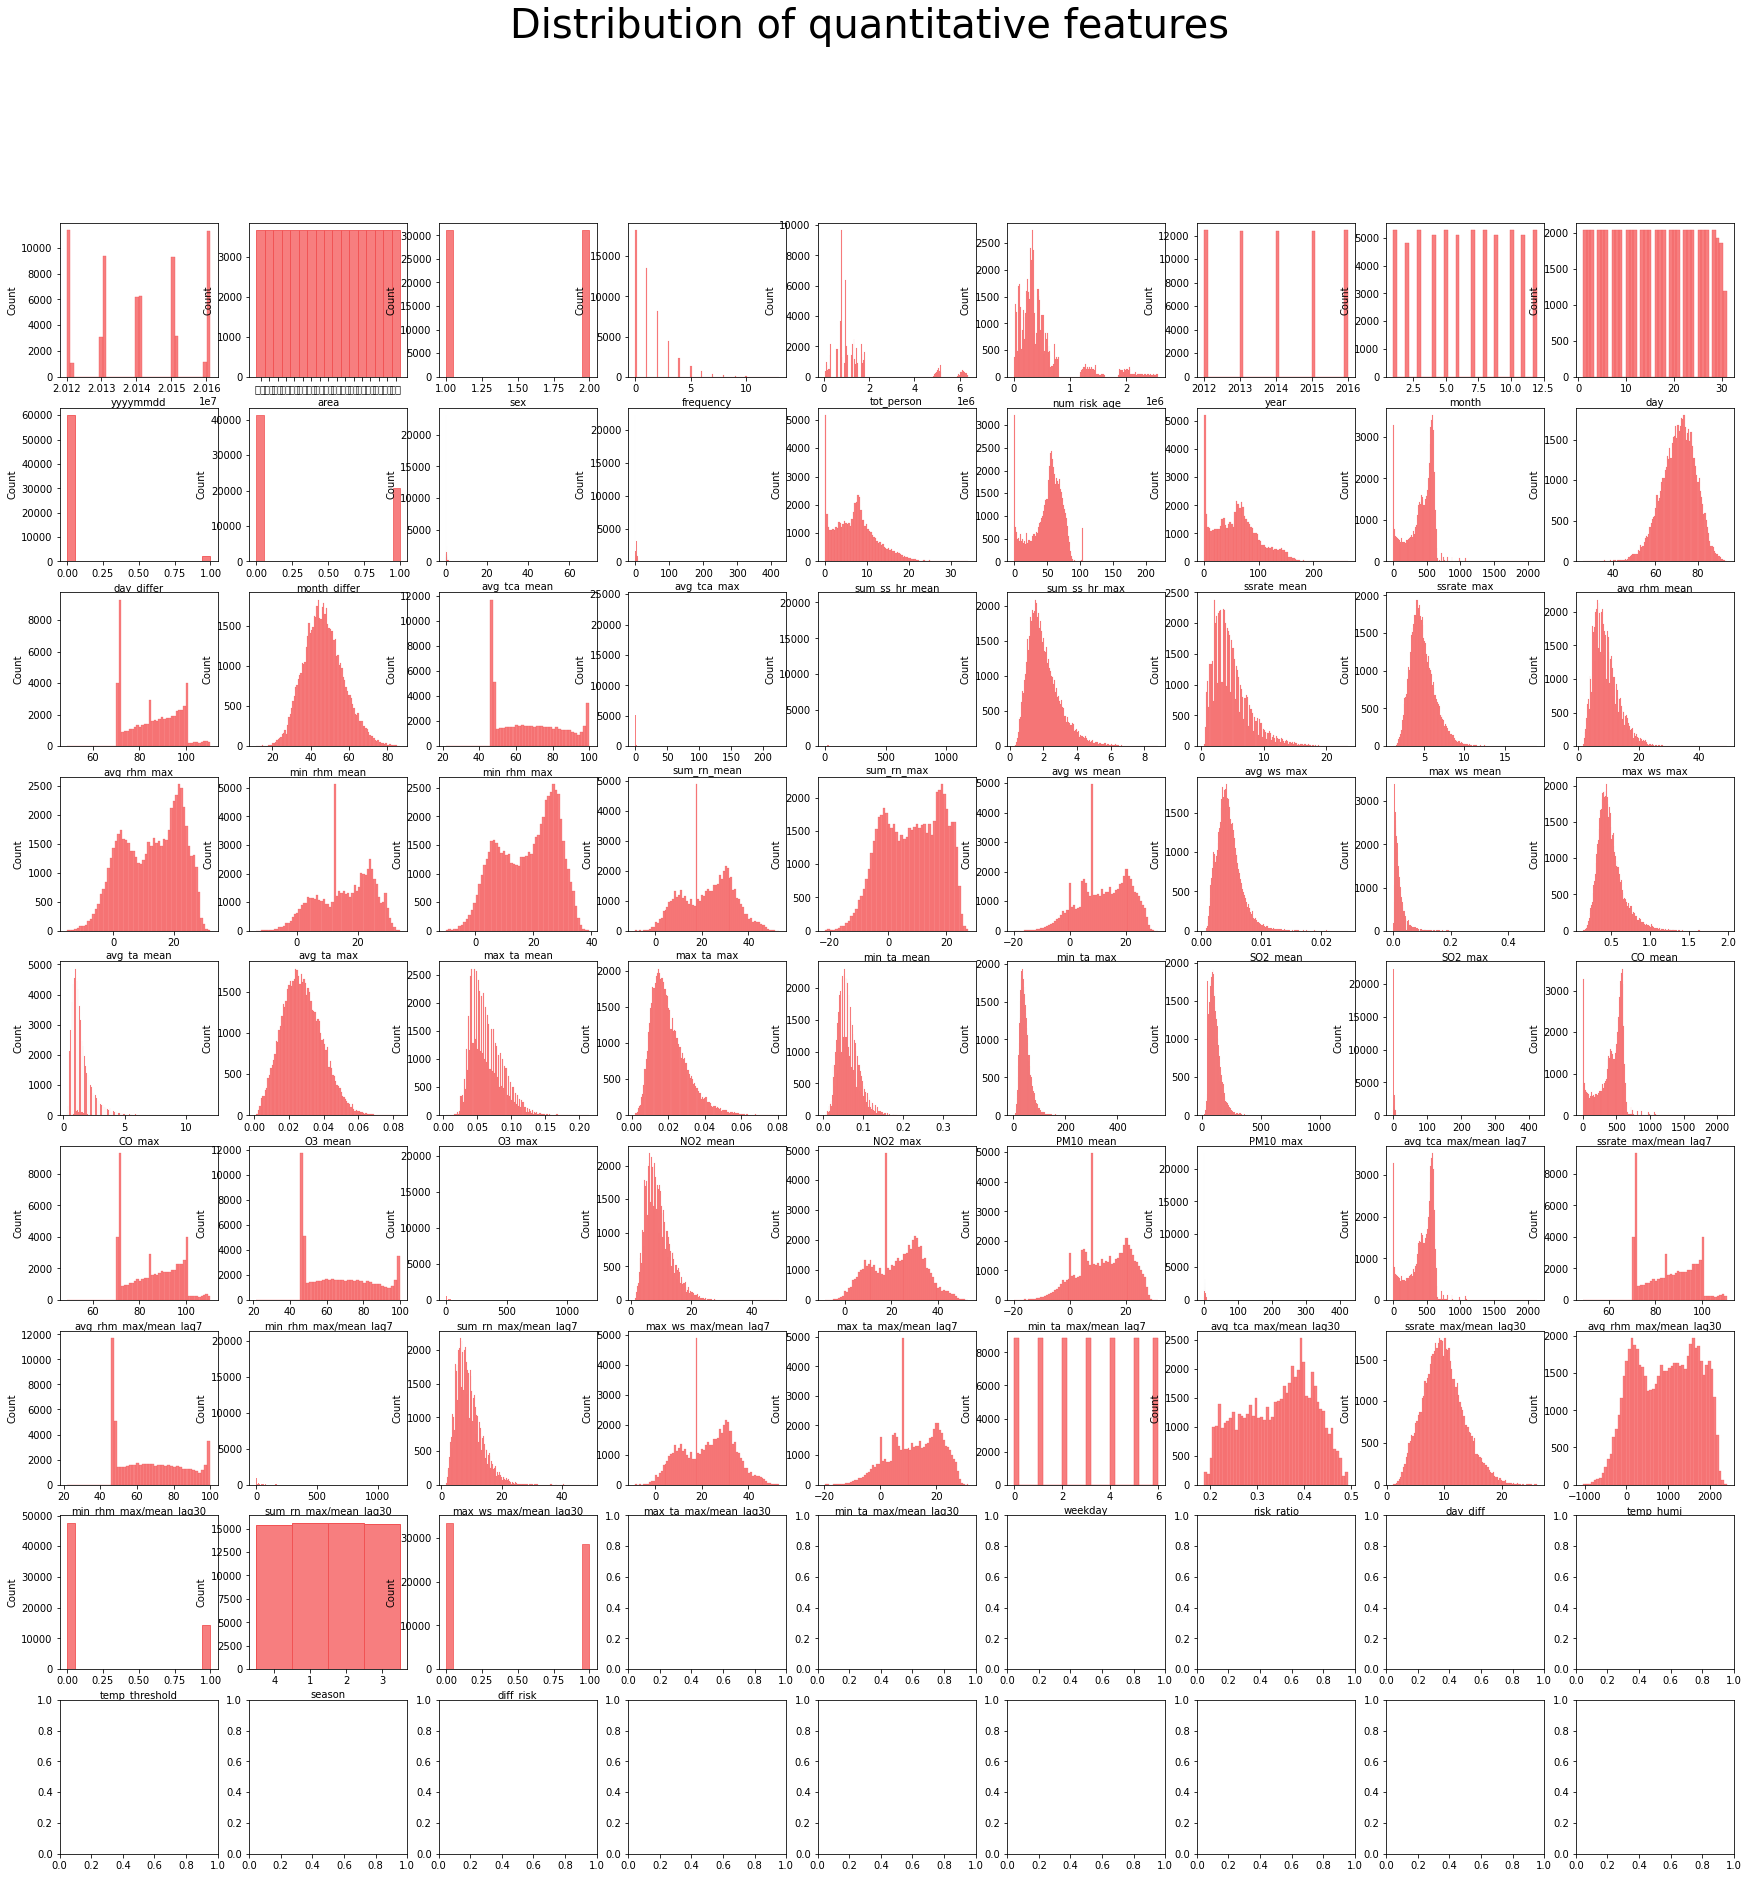

In [ ]:
import seaborn as sns 
fig, axes = plt.subplots(9, 9, figsize=(30, 30))
fig.suptitle('Distribution of quantitative features', fontsize=40)

for ax,feature in zip(axes.flatten(), final.columns):
    sns.histplot(data = final, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

In [ ]:
f,ax = plt.subplots(figsize=(25,25))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

In [ ]:
dates = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d').dt
df['weekday']= dates.weekday

In [ ]:
df['risk_ratio'] = df['num_risk_age'] / df['tot_person']

# 2. 모델링

## 1) pycaret

In [ ]:
from pycaret.regression import *

model = setup(
    data = train,
    target = 'frequency',
    fold = 5,
    use_gpu = True,
    session_id = 42
)

,Description,Value
0,session_id,42
1,Target,frequency
2,Original Data,"(49674, 56)"
3,Missing Values,False
4,Numeric Features,45
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(34771, 94)"


In [ ]:
top5_models = compare_models(
    round=3,
    sort='RMSE',
    n_select=5
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8.910000e-01,1.466000e+00,1.211000e+00,4.710000e-01,0.480,4.420000e-01,33.658
lightgbm,Light Gradient Boosting Machine,8.950000e-01,1.491000e+00,1.221000e+00,4.620000e-01,0.481,4.500000e-01,0.784
ridge,Ridge Regression,9.020000e-01,1.493000e+00,1.222000e+00,4.610000e-01,0.486,4.570000e-01,0.054
br,Bayesian Ridge,9.020000e-01,1.495000e+00,1.222000e+00,4.610000e-01,0.485,4.550000e-01,0.292
catboost,CatBoost Regressor,9.010000e-01,1.510000e+00,1.229000e+00,4.550000e-01,0.484,4.590000e-01,9.720
omp,Orthogonal Matching Pursuit,9.170000e-01,1.522000e+00,1.233000e+00,4.510000e-01,0.490,4.560000e-01,0.046
lr,Linear Regression,9.210000e-01,1.545000e+00,1.243000e+00,4.430000e-01,0.495,4.670000e-01,0.216
xgboost,Extreme Gradient Boosting,9.320000e-01,1.625000e+00,1.275000e+00,4.140000e-01,0.498,4.870000e-01,0.892
rf,Random Forest Regressor,9.400000e-01,1.645000e+00,1.282000e+00,4.070000e-01,0.504,4.940000e-01,52.284
en,Elastic Net,9.570000e-01,1.647000e+00,1.283000e+00,4.060000e-01,0.509,4.130000e-01,0.094


In [ ]:
tuned_models = [tune_model(i, n_iter = 15) for i in top6_models]

In [ ]:
blended_model = blend_models(tuned_models)

In [ ]:
final_model = finalize_model(blended_model)

## 2) CatBoostRegressor

In [ ]:
! pip install catboost

In [3]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
import random
random.seed(42)
np.random.seed(42)

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col
    
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')
hospital = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/hospital.csv', encoding='cp949')
new_merge_data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/new_merge_data.csv', encoding='cp949')
forecast = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/예보지수.csv', encoding='cp949')

In [ ]:
new_merge_data.columns

Index(['yyyymmdd', 'area', 'avg_tca_mean', 'avg_tca_max', 'sum_ss_hr_mean',
       'sum_ss_hr_max', 'ssrate_mean', 'ssrate_max', 'avg_rhm_mean',
       'avg_rhm_max', 'min_rhm_mean', 'min_rhm_max', 'sum_rn_mean',
       'sum_rn_max', 'avg_ws_mean', 'avg_ws_max', 'max_ws_mean', 'max_ws_max',
       'avg_ta_mean', 'avg_ta_max', 'max_ta_mean', 'max_ta_max', 'min_ta_mean',
       'min_ta_max', 'SO2_mean', 'SO2_max', 'CO_mean', 'CO_max', 'O3_mean',
       'O3_max', 'NO2_mean', 'NO2_max', 'PM10_mean', 'PM10_max'],
      dtype='object')

In [9]:
new_merge_data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/new_merge_data.csv', encoding='cp949')
# 지연효과 반영 
def add_lag_feature(dat, lag = None):

    cols = ['avg_tca_max', 'sum_ss_hr_max', 'ssrate_max', 'avg_rhm_max', 'min_rhm_max', 'sum_rn_max', 
            'max_ws_max','avg_ws_max','max_ta_max', 'min_ta_max', 'PM10_max']
    '''
    cols = ['avg_tca_mean','sum_ss_hr_mean', 'ssrate_mean','avg_rhm_mean', 'min_rhm_mean','sum_rn_mean', 
            'avg_ws_mean', 'max_ws_mean', 'avg_ta_mean', 'max_ta_mean', 'min_ta_mean', 'PM10_mean']
            
    cols = ['avg_tca_mean', 'avg_tca_max','sum_ss_hr_mean','sum_ss_hr_max', 'ssrate_mean', 
            'ssrate_max', 'avg_rhm_mean','avg_rhm_max', 'min_rhm_mean', 'min_rhm_max', 
            'sum_rn_mean', 'sum_rn_max', 'avg_ws_mean', 'avg_ws_max', 'max_ws_mean', 
            'max_ws_max','avg_ta_mean', 'avg_ta_max','max_ta_mean', 'max_ta_max', 
            'min_ta_mean', 'min_ta_max','PM10_mean','PM10_max']
    '''

    
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, min_periods=0, closed='left').mean().reset_index(0,drop=True)
   # lag_max = group_df[cols].rolling(window = lag, min_periods=0).max().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}/mean_lag{lag}'] = lag_mean[col]
   #     dat[f'{col}/max_lag{lag}'] = lag_max[col]
    return dat

add_lag_feature(new_merge_data, 2)
add_lag_feature(new_merge_data, 4)
add_lag_feature(new_merge_data, 7)

final = pd.merge(hospital, new_merge_data, how='left')
final = pd.merge(final, forecast, how='left')
final = final.sort_values(['yyyymmdd', 'sex', 'area']).reset_index(drop=True)
# 지금까진 2,4가 best, 1.1888
# 3,5 + closd = 'left(3 <= X < 6) => 0.18926

In [ ]:
# 새로운 변수 생성 
dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['max_ta_mean'] - final['min_ta_mean']     # 일교차 
final['temp_humi'] = final['avg_rhm_mean'] * final['avg_ta_mean']   # 습도 * 기온
# https://www.karger.com/Article/Fulltext/505122

final['temp_threshold'] = np.where((final['min_ta_mean'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070

conditionlist = [
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified')  # 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 

final = final.drop(['num_risk_age', 'sum_rn_mean', 'sum_ss_hr_mean',
                    'SO2_mean','SO2_max', 'CO_mean', 'CO_max', 'O3_mean', 'O3_max', 'NO2_mean','NO2_max',
                    'A03_t1_max', 'A03_t2_max', 'A03_t3_max', 
                    'A04_t1_max', 'A04_t2_max', 'A04_t3_max', 
                    'A05_t1_max', 'A05_t2_max', 'A05_t3_max', 
               #     'A06_t1_max', 'A06_t2_max', 'A06_t3_max',  
               #     'A07_t1_max',  'A07_t2_max','A07_t3_max'
                    ], axis=1)

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])

# 모델링 
CAT = CatBoostRegressor(verbose=2, random_state=42, one_hot_max_size = 17)
CAT.fit(X_train, y_train,
        cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 
                      'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk'],
        eval_set=(X_val, y_val),
        early_stopping_rounds = 300, use_best_model = True)

In [44]:
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')    
'''
CAT = CatBoostRegressor(verbose=2, random_state=42, one_hot_max_size = 17, 
                        cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk'] )             
'''
pred = CAT.predict(test)

year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

submit['frequency'] = pred * rate
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/220139.csv', encoding='cp949', index=False)

In [27]:
from tqdm import tqdm
CAT = CatBoostRegressor(verbose=1, random_seed=42, cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 
                      'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk'], one_hot_max_size = 17)
# K-Fold 
def kfold(model, tr):
    cv_accuracy = []
    cv = KFold(n_splits = 5, shuffle=True, random_state=42)
    n_iter = 0

    for t,v in tqdm(cv.split(tr, tr['frequency'])): 
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y, eval_set = [(val_X, val_y)],
                  early_stopping_rounds=200, verbose=False, use_best_model = True)
        score = RMSE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)
kfold(CAT, train)

5it [00:54, 10.99s/it]


1.213358960840091

### predict 10개 평균내기

In [26]:
# 최종 예측치 생성 ==> 그냥 full로 예측하고 끝내는 거랑 이거랑 비교해서 제출(stacking이 아닌 단순 집계로 앙상블 할 경우의 얘기)
#CAT = CatBoostRegressor(**study.Best_trial)
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]
CAT = CatBoostRegressor(verbose=1, random_seed=42, one_hot_max_size = 17, 
                  cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk'])
def kfold_predict(model, train, test, num):
    preds = np.zeros(test.shape[0])
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0
    rmse = []

    for t,v in cv.split(train, train['frequency']):#, groups=train['month']
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']
    
        model.fit(X, y, eval_set = [(val_X, val_y)],
                  early_stopping_rounds=200, verbose=False, use_best_model = True)
        
        preds += model.predict(test) / cv.n_splits

        rmse.append(RMSE(val_y, model.predict(val_X)))
        print(f'fold: {n_iter+1} ======> rmse : {rmse[n_iter]}')
        n_iter += 1
    print(f'total_mean ======> rmse : {np.mean(rmse)}')
    
    return preds
predict = kfold_predict(CAT, train, test, 10)

fold: 1 ======> rmse : 1.2217887342201548
fold: 2 ======> rmse : 1.2100689110765137
fold: 3 ======> rmse : 1.202345395975144
fold: 4 ======> rmse : 1.2306808385546302
fold: 5 ======> rmse : 1.2154816588945212
fold: 6 ======> rmse : 1.2278837649908334
fold: 7 ======> rmse : 1.2126416815205494
fold: 8 ======> rmse : 1.1938705087389678
fold: 9 ======> rmse : 1.2132387620689602
fold: 10 ======> rmse : 1.197291642689582
total_mean ======> rmse : 1.2125291898729853


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')    
submit['frequency'] = predict * rate
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/220139.csv', encoding='cp949', index=False)

## 3) LGBM

In [105]:
new_merge_data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/new_merge_data.csv', encoding='cp949')
# 지연효과 반영 
def add_lag_feature(dat, lag = None):

    cols = ['avg_tca_max', 'sum_ss_hr_max', 'ssrate_max', 'avg_rhm_max', 'min_rhm_max', 'sum_rn_max', 
            'max_ws_max','avg_ws_max','max_ta_max', 'min_ta_max', 'PM10_max']
    '''
    cols = ['avg_tca_mean','sum_ss_hr_mean', 'ssrate_mean','avg_rhm_mean', 'min_rhm_mean','sum_rn_mean', 
            'avg_ws_mean', 'max_ws_mean', 'avg_ta_mean', 'max_ta_mean', 'min_ta_mean', 'PM10_mean']
    cols = ['avg_tca_mean', 'avg_tca_max','sum_ss_hr_mean','sum_ss_hr_max', 'ssrate_mean', 
            'ssrate_max', 'avg_rhm_mean','avg_rhm_max', 'min_rhm_mean', 'min_rhm_max', 
            'sum_rn_mean', 'sum_rn_max', 'avg_ws_mean', 'avg_ws_max', 'max_ws_mean', 
            'max_ws_max','avg_ta_mean', 'avg_ta_max','max_ta_mean', 'max_ta_max', 
            'min_ta_mean', 'min_ta_max','PM10_mean','PM10_max']
    '''
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, min_periods=0, closed='left').mean().reset_index(0,drop=True)
   # lag_max = group_df[cols].rolling(window = lag, min_periods=0).max().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}/mean_lag{lag}'] = lag_mean[col]
   #     dat[f'{col}/max_lag{lag}'] = lag_max[col]
    return dat

add_lag_feature(new_merge_data, 3)
#add_lag_feature(new_merge_data, 4)
add_lag_feature(new_merge_data, 7)

final = pd.merge(hospital, new_merge_data, how='left')
final = pd.merge(final, forecast, how='left')
final = final.sort_values(['yyyymmdd', 'sex', 'area']).reset_index(drop=True)
# 지금까진 2,4가 best, 1.1888
# 3,5 + closd = 'left(3 <= X < 6) => 0.18926


# 새로운 변수 생성 
dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['max_ta_mean'] - final['min_ta_mean']     # 일교차 
final['temp_humi'] = final['avg_rhm_mean'] * final['avg_ta_mean']   # 습도 * 기온 https://www.karger.com/Article/Fulltext/505122
final['temp_threshold'] = np.where((final['min_ta_mean'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070

conditionlist = [
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified')  
final['season'] = final['season'].astype('category').cat.codes                   # 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 

final = final.drop(['yyyymmdd',
                    'num_risk_age', 'sum_rn_mean', 'sum_ss_hr_mean',
                    'SO2_mean','SO2_max', 'CO_mean', 'CO_max', 'O3_mean', 'O3_max', 'NO2_mean','NO2_max',
                    'A03_t1_max', 'A03_t2_max', 'A03_t3_max', 
                    'A04_t1_max', 'A04_t2_max', 'A04_t3_max', 
                    'A05_t1_max', 'A05_t2_max', 'A05_t3_max', 
               #     'A06_t1_max', 'A06_t2_max', 'A06_t3_max',  
               #     'A07_t1_max',  'A07_t2_max','A07_t3_max'
                    ], axis=1)
cat_features = ['area']
for i in enumerate(cat_features) :
    ca = i[1]
    final[ca] = final[ca].astype('category')

# train, test split
train = final[final['year'] != 2016]
test = final[final['year'] == 2016].drop('frequency', axis=1)

In [106]:
LGBM = LGBMRegressor(objective='mse', verbose=1, metric='rmse', random_state=42, n_jobs=-1,
                     learning_rate=0.1, n_estimators = 3000, max_depth = 100)
# K-Fold 
def kfold(model, tr, num):
    cv_accuracy = []
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0

    for t,v in cv.split(tr, tr['frequency']): 
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y, eval_set=(val_X, val_y), early_stopping_rounds=200, verbose=False)
        score = RMSE(val_y, model.predict(val_X))
        print(f'{n_iter+1} rmse ======> {score}')

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)
kfold(LGBM, train, 5)

1 rmse ======> 1.2155829274152596
2 rmse ======> 1.2176323119179253
3 rmse ======> 1.2254515303336113
4 rmse ======> 1.2034333705683284
5 rmse ======> 1.2080279760977413


1.2140256232665732